In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.2'

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# Using word embeddings

This notebook contains the second code sample found in Chapter 6, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---


Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". 
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the 
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors 
(i.e. "dense" vectors, as opposed to sparse vectors). 
Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. 
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 

![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 

Let's take a look at both.

## Learning word embeddings with the `Embedding` layer


The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the 
resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different 
embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of 
such a noisy, unstructured embedding space. 

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. 
Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect 
synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two 
word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points 
far away from each other, while related words would be closer). Even beyond mere distance, we may want specific __directions__ in the 
embedding space to be meaningful. 

[...]


In real-world word embedding spaces, common examples of meaningful geometric transformations are "gender vectors" and "plural vector". For 
instance, by adding a "female vector" to the vector "king", one obtain the vector "queen". By adding a "plural vector", one obtain "kings". 
Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Is there some "ideal" word embedding space that would perfectly map human language and could be used for any natural language processing 
task? Possibly, but in any case, we have yet to compute anything of the sort. Also, there isn't such a thing as "human language", there are 
many different languages and they are not isomorphic, as a language is the reflection of a specific culture and a specific context. But more 
pragmatically, what makes a good word embedding space depends heavily on your task: the perfect word embedding space for an 
English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language 
legal document classification model, because the importance of certain semantic relationships varies from task to task.

It is thus reasonable to __learn__ a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it 
even easier. It's just about learning the weights of a layer: the `Embedding` layer.

In [4]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)


The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.


The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then 
be processed by a RNN layer or a 1D convolution layer (both will be introduced in the next sections).

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), 
and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` 
layer on top for classification.

In [5]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 100

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 19s 1us/step


In [6]:
x_train[:5]
#y_train[:5]


array([[1415,   33,    6,   22,   12,  215,   28,   77,   52,    5,   14,
         407,   16,   82,    2,    8,    4,  107,  117, 5952,   15,  256,
           4,    2,    7, 3766,    5,  723,   36,   71,   43,  530,  476,
          26,  400,  317,   46,    7,    4,    2, 1029,   13,  104,   88,
           4,  381,   15,  297,   98,   32, 2071,   56,   26,  141,    6,
         194, 7486,   18,    4,  226,   22,   21,  134,  476,   26,  480,
           5,  144,   30, 5535,   18,   51,   36,   28,  224,   92,   25,
         104,    4,  226,   65,   16,   38, 1334,   88,   12,   16,  283,
           5,   16, 4472,  113,  103,   32,   15,   16, 5345,   19,  178,
          32],
       [ 163,   11, 3215,    2,    4, 1153,    9,  194,  775,    7, 8255,
           2,  349, 2637,  148,  605,    2, 8003,   15,  123,  125,   68,
           2, 6853,   15,  349,  165, 4362,   98,    5,    4,  228,    9,
          43,    2, 1157,   15,  299,  120,    5,  120,  174,   11,  220,
         175,  136,   5

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 8)            80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 801       
Total params: 80,801
Trainable params: 80,801
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 114us/step - loss: 0.6228 - acc: 0.6770 - val_loss: 0.4767 - val_acc: 0.8034
Epoch 2/10
20000/20000 [==============================] - 2s 104us/step - loss: 0.3741 - acc: 0.8502 - val_loss: 0.3537 - val_acc: 0.8456
Epoch 3/10
20000/20000 [==============================] - 2s 106us/step - los

In [ ]:
## experiment with different model types
model2 = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model2.add(Embedding(10000, 20, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model2.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

We get to a validation accuracy of ~76%, which is pretty good considering that we only look at the first 20 words in every review. But 
note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the 
input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both _"this movie 
is shit"_ and _"this movie is the shit"_ as being negative "reviews"). It would be much better to add recurrent layers or 1D convolutional 
layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That's what we will focus on in 
the next few sections.

## Using pre-trained word embeddings


Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding 
of your vocabulary. What to do then?

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed 
embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The 
rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets 
in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that 
we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a 
different problem.

Such word embeddings are generally computed using word occurrence statistics (observations about what words co-occur in sentences or 
documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space 
for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking 
off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec 
algorithm, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras `Embedding` layer. Word2Vec is one 
of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word 
Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made 
available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.

Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec 
embeddings or any other word embedding database that you can download. We will also use this example to refresh the text tokenization 
techniques we introduced a few paragraphs ago: we will start from raw text, and work our way up.

## Putting it all together: from raw text to word embeddings


We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a 
`Dense` layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in 
Keras, we will start from scratch, by downloading the original text data.

### Download the IMDB data as raw text


First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just 
Google "IMDB dataset"). Uncompress it.

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels 
(positive / negative) into a `labels` list:

In [20]:
import os

imdb_dir = '/home/deeplearning/NLP/DeepLearningWithPython/deep-learning-with-python-notebooks/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [5]:
## read in the Tweeter data
import os

tweet = '/home/deeplearning/NLP/DeepLearningWithPython/deep-learning-with-python-notebooks/Tweet/tweets_large.csv'
tweet=''
labels = []
texts = []

f = open(tweet,'r')
for line in f:
    

        #print(line)
    split_line=line.rstrip().replace('"','').split(",")
    cat=split_line[-1]
    text=','.join(split_line[:len(split_line)-1])
    #print(cat)
    #print(text)
    texts.append(text)
    labels.append(cat)
f.close()


In [6]:
texts[:5]
labels[:5]
len(texts)
len(labels)


['Flying in The States used to be a pleasant experience. Thanks for ruining that',
 'are box allowed as checked in luggage?',
 'hello, i was unable to add my skymiles # to my trip today. can you help me?',
 'hey  can I transfer my points earned from flying to hilton honor points?',
 'will be missing flight 3453 to Columbia due to closed precheck and inefficient security at ORD. Any suggestions?']

['complaint', 'request', 'request', 'request', 'request']

19794

19794

In [7]:
## check the length of the text
length_text=[len(s) for s in texts]
#length_text
max(length_text)

import statistics
sum(length_text)/len(length_text)
statistics.median(length_text)



179

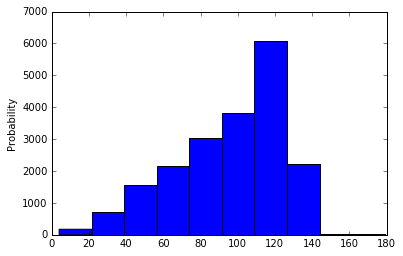

In [20]:
## plot length distribution

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#x = np.random.normal(size = 1000)
plt.hist(length_text)
plt.ylabel('Probability');

### Tokenize the data


Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, 
task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 
samples. So we will be learning to classify movie reviews after looking at just 200 examples...


In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 16000  # We will be training on 200 samples
validation_samples = 3600  # We will be validating on 10000 samples
max_words = 13000  # We will only consider the top 13,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

Found 13849 unique tokens.


In [22]:
### transform three class Y into dummy variables
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_labels = np_utils.to_categorical(encoded_Y)

LabelEncoder()

In [23]:
dummy_labels[:5]
labels[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

['complaint', 'request', 'request', 'request', 'request']

In [24]:
data[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   54,   11,
           2, 3119,  610,    1,   40,    5,  645,  100,   14,    4,  715,
          38],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

In [25]:
#labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', dummy_labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
dummy_labels = dummy_labels[indices]

x_train = data[:training_samples]
y_train = dummy_labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = dummy_labels[training_samples: training_samples + validation_samples]

Shape of data tensor: (19794, 100)
Shape of label tensor: (19794, 3)


### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [26]:
glove_dir = '/home/deeplearning/Downloads'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.



Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [27]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [28]:
embedding_matrix[:5]

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

### Define a model

We will be using the same model architecture as before:

In [29]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1300000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 1,620,131
Trainable params: 1,620,131
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [30]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient updated triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

### Train and evaluate

Let's compile our model and train it:

In [31]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              #loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 16000 samples, validate on 3600 samples
Epoch 1/10
16000/16000 [==============================] - 7s 434us/step - loss: 0.6725 - acc: 0.7132 - val_loss: 0.5760 - val_acc: 0.7667
Epoch 2/10
16000/16000 [==============================] - 6s 399us/step - loss: 0.4137 - acc: 0.8404 - val_loss: 0.4484 - val_acc: 0.8300
Epoch 3/10
16000/16000 [==============================] - 7s 408us/step - loss: 0.2943 - acc: 0.8926 - val_loss: 0.4150 - val_acc: 0.8414
Epoch 4/10
16000/16000 [==============================] - 8s 507us/step - loss: 0.2095 - acc: 0.9256 - val_loss: 0.4204 - val_acc: 0.8528
Epoch 5/10
16000/16000 [==============================] - 10s 597us/step - loss: 0.1448 - acc: 0.9519 - val_loss: 0.3799 - val_acc: 0.8725
Epoch 6/10
16000/16000 [==============================] - 10s 608us/step - loss: 0.0895 - acc: 0.9758 - val_loss: 0.3642 - val_acc: 0.8972
Epoch 7/10
16000/16000 [==============================] - 7s 426us/step - loss: 0.0535 - acc: 0.9888 - val_loss: 0.3677 -

Let's plot its performance over time:

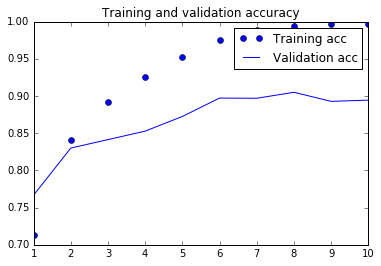

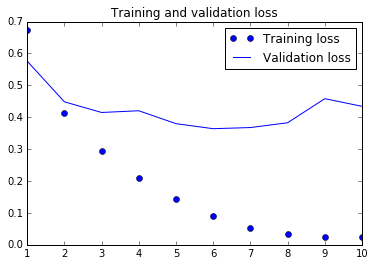

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we 
picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the 
sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [33]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1300000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 1,620,131
Trainable params: 1,620,131
Non-trainable params: 0
_________________________________________________________________
Train on 16000 samples, validate on 3600 samples
Epoch 1/10
16000/16000 [==============================] - 19s 1ms/step - loss: 0.7174 - acc: 0.6758 - val_loss: 0.4773 - val_acc: 0.8025
Epoch 2/10
16000/16000 [==============================] - 22s 1ms/step - loss:

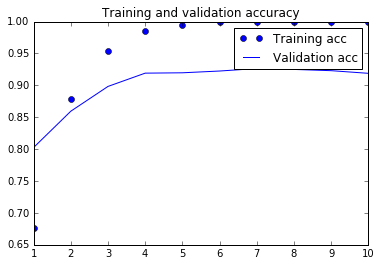

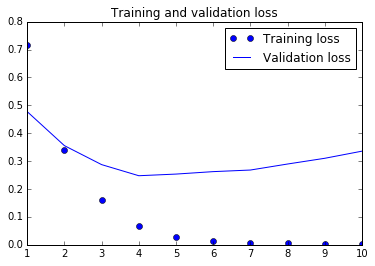

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you 
increase the number of training samples, this will quickly stop being the case -- try it as an exercise.

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

Now we start to use the 1D Convolution layer rather than simply unfold the embedding layers 

In [36]:
from keras.layers import Embedding, Flatten, Dense,Dropout, Activation
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras import metrics

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(64,3,
                     padding='valid',
                     activation='relu',
                     strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history_CNN1 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1300000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 64)            19264     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
__________

Now let's Visualize the accuracy for the CNN_model1

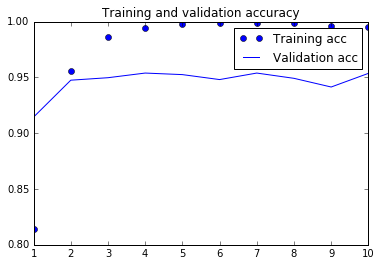

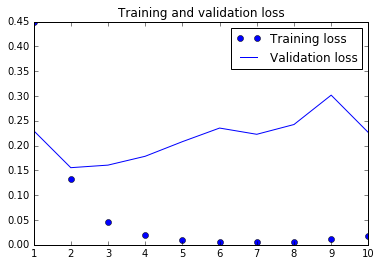

In [37]:
acc = history_CNN1.history['acc']
val_acc = history_CNN1.history['val_acc']
loss = history_CNN1.history['loss']
val_loss = history_CNN1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
from keras.layers import Embedding, Flatten, Dense,Dropout, Activation
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras import metrics

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(64,3,
                     padding='valid',
                     activation='relu',
                     strides=1))
model.add(Conv1D(32,3,
                     padding='valid',
                     activation='relu',
                     strides=1))
model.add(Conv1D(16,3,
                     padding='valid',
                     activation='relu',
                     strides=1))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history_CNN2 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1300000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 98, 64)            19264     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 32)            6176      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 94, 16)            1552      
_________________________________________________________________
flatten_3 (Flatten)          (None, 1504)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1504)              0         
__________

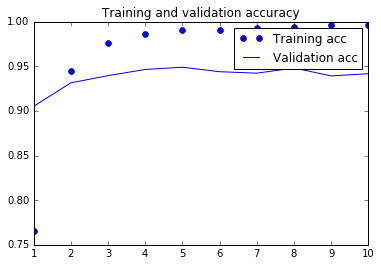

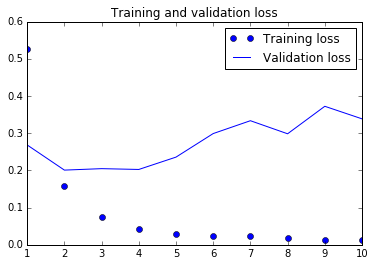

In [39]:
acc = history_CNN2.history['acc']
val_acc = history_CNN2.history['val_acc']
loss = history_CNN2.history['loss']
val_loss = history_CNN2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Let's try another CNN architecture, similar as what described in https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [58]:
from keras.layers import Embedding, Flatten, Dense,Dropout, Activation
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D 
from keras import metrics

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Conv1D(128,3,activation='relu'))
model.add(MaxPooling1D(pool_length=5))
model.add(Conv1D(128,3,activation='relu'))
model.add(MaxPooling1D(pool_length=17))  ## global max 
model.add(Flatten()) 
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 100)          1300000   
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 19, 128)           0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 17, 128)           49280     
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
__________

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=5)`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:11: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=17)`


In [59]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history_CNN3 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 16000 samples, validate on 3600 samples
Epoch 1/10
16000/16000 [==============================] - 39s 2ms/step - loss: 0.5116 - acc: 0.7778 - val_loss: 0.3174 - val_acc: 0.8750
Epoch 2/10
16000/16000 [==============================] - 39s 2ms/step - loss: 0.1804 - acc: 0.9372 - val_loss: 0.2460 - val_acc: 0.9172
Epoch 3/10
16000/16000 [==============================] - 38s 2ms/step - loss: 0.0766 - acc: 0.9714 - val_loss: 0.2421 - val_acc: 0.9225
Epoch 4/10
16000/16000 [==============================] - 39s 2ms/step - loss: 0.0403 - acc: 0.9849 - val_loss: 0.3568 - val_acc: 0.9114
Epoch 5/10
16000/16000 [==============================] - 40s 2ms/step - loss: 0.0337 - acc: 0.9871 - val_loss: 0.3341 - val_acc: 0.9297
Epoch 6/10
16000/16000 [==============================] - 42s 3ms/step - loss: 0.0349 - acc: 0.9869 - val_loss: 0.3223 - val_acc: 0.9308
Epoch 7/10
16000/16000 [==============================] - 39s 2ms/step - loss: 0.0299 - acc: 0.9882 - val_loss: 0.4142 - val_acc:

Now let's try to implement CNN with different filter size and concatenate them together, similar as what described in Yoon Kim’s paper 

In [63]:
from keras.layers import Embedding, Flatten, Dense,Dropout, Activation, Concatenate, add,Merge
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras import metrics
from keras.models import Model

In [80]:
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model
# applying a more complex convolutional approach
convs = []
filter_sizes = [3,4,5]
MAX_SEQUENCE_LENGTH=maxlen

#model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')


embedding_layer = Embedding(max_words,
                            embedding_dim,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            #trainable=True
                           )

embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(nb_filter=64,filter_length=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
l_merge = Merge(mode='concat', concat_axis=1)(convs)
l_cov1= Conv1D(64, 5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(64, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(6)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(3, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print("model fitting - more complex convolutional neural network")
model.summary()

#model.fit(x_train, y_train, validation_data=(x_val, y_val),
 #         nb_epoch=20, batch_size=50)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:25: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", kernel_size=3, filters=64)`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:25: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", kernel_size=4, filters=64)`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:25: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", kernel_size=5, filters=64)`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:29: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


model fitting - more complex convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_55 (Embedding)        (None, 100, 100)     1300000     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_98 (Conv1D)              (None, 98, 64)       19264       embedding_55[0][0]               
__________________________________________________________________________________________________
conv1d_99 (Conv1D)              (None, 97, 64)       25664       embedding_55[0][0]               
___________________________________________________

In [81]:
#model.compile(optimizer='adam',
 #             loss='categorical_crossentropy',
  #            metrics=['acc'])
history_CNN_concat = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 16000 samples, validate on 3600 samples
Epoch 1/10
16000/16000 [==============================] - 64s 4ms/step - loss: 0.5068 - acc: 0.7773 - val_loss: 0.3123 - val_acc: 0.8778
Epoch 2/10
16000/16000 [==============================] - 60s 4ms/step - loss: 0.1523 - acc: 0.9472 - val_loss: 0.2716 - val_acc: 0.9122
Epoch 3/10
16000/16000 [==============================] - 61s 4ms/step - loss: 0.0560 - acc: 0.9803 - val_loss: 0.2209 - val_acc: 0.9361
Epoch 4/10
16000/16000 [==============================] - 76s 5ms/step - loss: 0.0259 - acc: 0.9913 - val_loss: 0.4391 - val_acc: 0.9144
Epoch 5/10
16000/16000 [==============================] - 77s 5ms/step - loss: 0.0209 - acc: 0.9926 - val_loss: 0.3167 - val_acc: 0.9317
Epoch 6/10
16000/16000 [==============================] - 79s 5ms/step - loss: 0.0236 - acc: 0.9911 - val_loss: 0.3693 - val_acc: 0.9314
Epoch 7/10
16000/16000 [==============================] - 78s 5ms/step - loss: 0.0180 - acc: 0.9937 - val_loss: 0.4157 - val_acc:

In [72]:
fsz=3

model1 = Sequential()
model1.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model1.add(Dropout(0.2))
model1.add(Conv1D(64,fsz,padding='valid',activation='relu',strides=1))
model1.add(MaxPooling1D(pool_length=5))
model1.summary()


fsz=4

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(Dropout(0.2))
model2.add(Conv1D(64,fsz,padding='valid',activation='relu',strides=1))
model2.add(MaxPooling1D(pool_length=5))
model2.summary()

fsz=5

model3 = Sequential()
model3.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model3.add(Dropout(0.2))
model3.add(Conv1D(64,fsz,padding='valid',activation='relu',strides=1))
model3.add(MaxPooling1D(pool_length=5))
model3.summary()


merged=Concatenate([model1, model2])
### Concantenent the three filter Con map together
result=Model(Concatenate([merged,model3]))

#model.add(Concatenate([model1,model2,model3]))
#model.add(GlobalMaxPooling1D())
#model.add(Dense(256))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
#model.add(Dense(3, activation='softmax'))
result.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 100, 100)          1300000   
_________________________________________________________________
dropout_43 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 98, 64)            19264     
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 19, 64)            0         
Total params: 1,319,264
Trainable params: 1,319,264
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_53 (Embedding)     (None, 100, 100)          1300000   
_________________________________________________________________


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:7: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=5)`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:17: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=5)`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:26: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=5)`


NameError: name 'Model' is not defined

In [36]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history_CNN1 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1300000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 64)            19264     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
__________

In [24]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [25]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

24736/25000 [============================>.] - ETA: 0s

[0.93747248332977295, 0.53659999999999997]

We get an appalling test accuracy of 54%. Working with just a handful of training samples is hard!